# 필요 라이브러리 설치 및 파일 셋업

In [ ]:
!pip install IPython 
# !pip install catboost
# !pip install optuna

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 

import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
import time

In [3]:
# 50개까지 row 생략 없이 출력
pd.set_option('display.max_rows', 50)
# 50개까지 col 생략 없이 출력
pd.set_option('display.max_columns', 50)

In [4]:
user_spec = pd.read_csv("./../data/user_spec.csv") 
log_data = pd.read_csv("./../data/log_data.csv")
loan_result = pd.read_csv("./../data/loan_result.csv")

In [5]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

In [6]:
print('loan_result.shape:{}'.format(loan_result.shape))
print('log_data.shape:{}'.format(log_data.shape))
print('user_spec.shape:{}'.format(user_spec.shape))

loan_result.shape:(13527363, 7)
log_data.shape:(17843993, 6)
user_spec.shape:(1394216, 17)


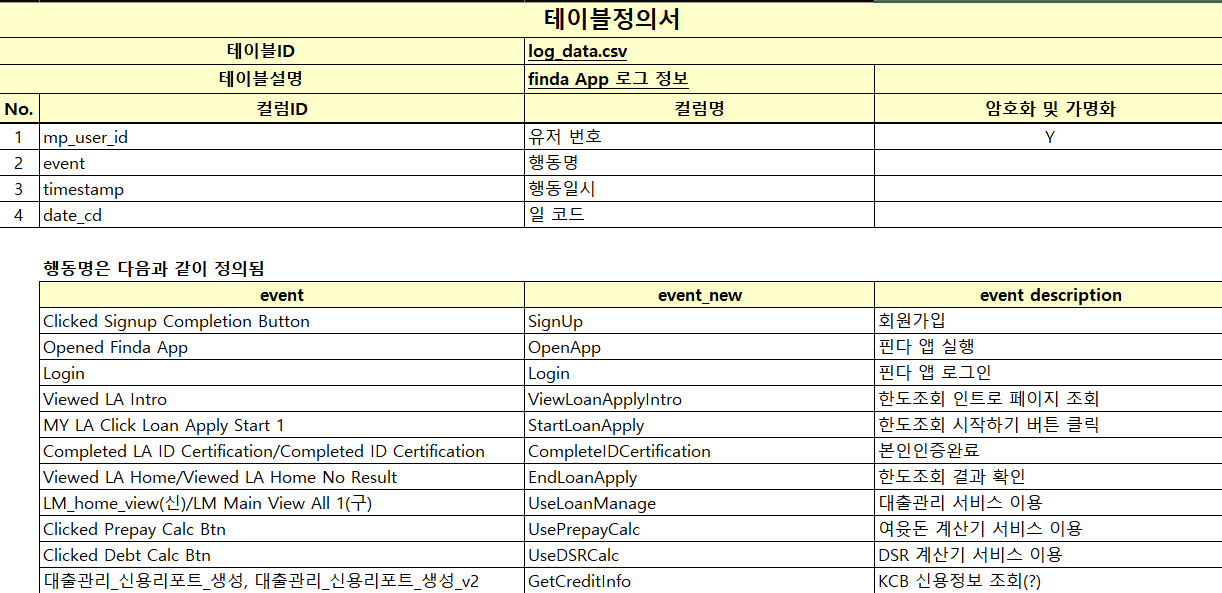

In [176]:
Image('./../data/log_data.png')

# 전처리

## 데이터 확인

In [177]:
log_data.head(10) # 상위 5개 확인

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25
5,640185,UseLoanManage,2022-03-25 11:41:53,iOS,3.6.1,2022-03-25
6,640185,ViewLoanApplyIntro,2022-03-25 11:42:38,iOS,3.6.1,2022-03-25
7,640185,UsePrepayCalc,2022-03-25 11:43:07,iOS,3.6.1,2022-03-25
8,640185,UseLoanManage,2022-03-25 11:43:57,iOS,3.6.1,2022-03-25
9,640185,UseLoanManage,2022-03-25 11:44:04,iOS,3.6.1,2022-03-25


In [178]:
log_data.info() # 컬럼 타입 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17843993 entries, 0 to 17843992
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   유저_번호   int64 
 1   행동명     object
 2   행동일시    object
 3   운영체제    object
 4   앱_버전    object
 5   일_코드    object
dtypes: int64(1), object(5)
memory usage: 816.8+ MB


In [179]:
log_data.isnull().sum() # 결측치 확인 

유저_번호         0
행동명           0
행동일시          0
운영체제        980
앱_버전     660597
일_코드          0
dtype: int64

## 결측치 처리
- 운영체제 결측 처리

In [6]:
log_data['운영체제'].unique()

array(['Android', 'iOS', 'iPadOS', 'android', nan], dtype=object)

android로 되어 있는 데이터들의 mp_os는 전부 GetCreditInfo에 해당된다 -> Android로 변환

In [7]:
log_data[log_data['운영체제']=='android']['행동명'].unique()

array(['GetCreditInfo'], dtype=object)

In [8]:
log_data.loc[list(log_data[log_data['운영체제']=='android'].index),'운영체제'] = 'Android'

In [9]:
log_data[log_data['운영체제'].isnull()].isnull().sum()

유저_번호      0
행동명        0
행동일시       0
운영체제     980
앱_버전     980
일_코드       0
dtype: int64

- 유저 ID에 해당하는 mp_os가 nan만 있을경우: 처리 못함
- 유저 ID에 해당하는 mp_os가 1개 있을경우: 1개로 nan값 처리
    - ipados에 해당하는 경우 없어서 그냥 나머지 1개로 처리 가능할듯
- 유저 ID에 해당하는 mp_os가 2개 있을경우: 처리 못함

GetCreditInfo 과정에서 map_os에 대한 결측이 이뤄짐

In [10]:
log_data[log_data['운영체제'].isnull()]['행동명'].value_counts()

GetCreditInfo    980
Name: 행동명, dtype: int64

In [10]:
only_user_id = [] 
ios_user = []
android_user = []

count1 = 0
count2 = 0

null_mp_os = list(log_data[log_data['운영체제'].isnull()]['유저_번호'].unique()) # mp_os가 null값인 user_id 목록

for i in null_mp_os:
    if len(log_data[log_data['유저_번호']==i]['운영체제'].unique())==1:
        only_user_id.append(i)
        count1+=1
    if len(log_data[log_data['유저_번호']==i]['운영체제'].unique())==2:
        count2+=1
        if 'Android' in list(log_data[log_data['유저_번호']==i]['운영체제'].unique()):
            android_user.append(i)
        else: ios_user.append(i)    
print('mp_os의 정보가 나오지 않는 유저의 수: {}'.format(count1))
print('mp_os의 정보가 한개 나오는 유저의수: {}'.format(count2))

mp_os의 정보가 나오지 않는 유저의 수: 9
mp_os의 정보가 한개 나오는 유저의수: 54


In [11]:
# ios 유저일 경우 ios로 null값 처리
log_data.loc[log_data['유저_번호'].isin(ios_user),'운영체제'] = 'iOS'
# android 유저일 경우 android로 null값 처리
log_data.loc[log_data['유저_번호'].isin(android_user),'운영체제'] = 'Android'

In [12]:
log_data.isnull().sum()

유저_번호         0
행동명           0
행동일시          0
운영체제        334
앱_버전     660597
일_코드          0
dtype: int64

In [13]:
log_data[log_data['운영체제'].isnull()]

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
462777,583660,GetCreditInfo,2022-05-01 21:58:34,NaN,NaN,2022-05-01
647827,725353,GetCreditInfo,2022-05-05 18:52:32,NaN,NaN,2022-05-05
647830,725353,GetCreditInfo,2022-05-05 18:52:43,NaN,NaN,2022-05-05
647831,725353,GetCreditInfo,2022-05-05 18:52:52,NaN,NaN,2022-05-05
822500,725353,GetCreditInfo,2022-03-05 18:55:44,NaN,NaN,2022-03-05
...,...,...,...,...,...,...
16286745,583660,GetCreditInfo,2022-03-20 16:05:00,NaN,NaN,2022-03-20
16286746,583660,GetCreditInfo,2022-03-20 16:05:02,NaN,NaN,2022-03-20
16286748,583660,GetCreditInfo,2022-03-20 16:05:21,NaN,NaN,2022-03-20
16718521,725353,GetCreditInfo,2022-05-17 11:40:32,NaN,NaN,2022-05-17


운영체제 중 andorid의 비중이 가장 크다

In [14]:
log_data['운영체제'].value_counts()

Android    14527765
iOS         3312865
iPadOS         3029
Name: 운영체제, dtype: int64

운영체제가 null값을 가지는 유저는 20명이라 android로 채워도 무방할듯

In [15]:
log_data[log_data['운영체제'].isnull()]['유저_번호'].unique()

array([583660, 725353, 174650, 613848, 567073, 851105, 800152, 653151,
       755444, 601422, 371601, 510091,  46822, 207017, 502992, 346408,
       329617, 165328, 445361, 317725])

In [16]:
log_data.loc[log_data['운영체제'].isnull(),'운영체제'] ='Android'

mp_app_version이 null값인 경우 ios의 분포가 가장 높다.

In [17]:
log_data[log_data['앱_버전'].isnull()]['운영체제'].value_counts()

iOS        658681
Android       980
iPadOS        936
Name: 운영체제, dtype: int64

- android는 3.8.2, 435, 3.8.0.6.mydata 등 버전 형태가 다양하다
- ios는 3.6.1 형식의 버전만 존재

In [18]:
log_data[log_data['운영체제'] == 'Android']['앱_버전'].unique()

array(['3.8.2', '3.8.4', '3.8.1', '3.8.0', '3.5.0', '3.5.3', '3.7.0',
       '3.2.2', '3.13.0', '3.12.1', '3.11.1', '3.10.0', '3.2.0', '3.3.2',
       '3.5.2', '3.11.0', '3.10.1', '3.9.1', '3.12.0', '3.0.2', '3.3.1',
       '3.9.0', '3.15.0', '3.15.1', '3.14.0', '3.6.0', '3.4.0', '3.5.1',
       '2.31.2', '3.1.1', '2.28.1', '3.2.1', '3.1.0', '3.0.1', '3.10.0.7',
       '3.10.1.0-dsr', '3.0.0', '3.10.1.2', '3.12.0.0', '453', '417',
       '413', '435', '461', '422', '409', '356', '359', '462', '370',
       '459', '451', '421', '383', '401', '464', '448', '466', '447', nan,
       '407', '416', '396', '440', '460', '380', '465', '404', '426',
       '408', '360', '376', '354', '363', '449', '368', '433', '387',
       '399', '361', '405', '452', '373', '385', '390', '424', '397',
       '382', '389', '2.24.2', '2.28.3', '3.10.1.0', '2.28.4', '3.10.2.2',
       '2.28.6', '3.8.0.6.mydata', '381', '406', '400', '2.27.4', '365',
       '366', '374', '432', '403', '384', '353', '379', '463',

In [19]:
log_data[log_data['운영체제'] == 'iOS']['앱_버전'].unique()

array(['3.6.1', '3.6.0', '3.10.2', '3.10.1', '3.10.0', '3.7.0', '3.8.0',
       '3.13.0', nan, '3.8.1', '3.6.2', '3.12.0', '3.12.1', '3.13.2',
       '3.13.1', '2.2.8', '3.3.2', '3.3.1', '1.2.4', '3.1.1', '3.3.0',
       '3.2.4', '3.4.0', '3.5.0', '3.1.0', '3.2.2', '2.24.5', '1.6.5',
       '2.28.2', '3.0.1', '2.28.4', '2.31.1', '3.4.1', '2.27.0', '1.9.1',
       '2.0.7', '3.2.1', '2.25.3', '2.0.3', '1.9.8', '3.2.3', '2.23.3',
       '2.2.3', '2.22.4', '3.5.1', '3.11.0', '2.1.5', '2.30.4', '3.2.0',
       '2.2.9', '2.1.7', '1.2.1', '2.30.6', '2.24.3', '2.1.8', '2.28.3',
       '2.23.0', '2.22.6', '1.7.6', '2.28.5', '1.9.9', '2.24.4', '2.25.0',
       '1.1.7', '1.5.2', '2.25.1', '2.28.1', '1.8.4', '2.22.2', '1.0.1',
       '2.23.4', '2.2.7', '2.30.2', '1.6.4', '2.22.7', '2.30.0', '2.23.2',
       '1.5.5', '1.0.3', '3.13.3', '3.0.0', '1.6.1', '1.1.6', '2.24.2',
       '2.30.3', '1.4.1', '2.1.4', '1.3.6', '1.0.0', '2.23.1', '1.1.5',
       '1.0.5', '1.1.9', '2.30.1'], dtype=object)

## 이상치 확인

In [62]:
# 혹시 행동일시랑 일_코드랑 일자 일치 하지 않는 컬럼 있는지 확인

log_data["일_코드_확인"] = log_data["행동일시"].str[0:10]

for i in tqdm(range(17843993)) :
    if log_data.일_코드.loc[i] != log_data.일_코드_확인.loc[i] :
        print(log_data.loc[i])
    else : continue

print("검사종료")

100%|██████████| 17843993/17843993 [09:43<00:00, 30587.09it/s]

검사종료


## 이벤트 명 한글 맵핑 및 행동일시 Slicing

In [20]:

# 범주형 변수의 항목 매핑/변환에 사용할 기준 정보를 dict 자료형으로 만들기
name_mapping = {
                    "SignUp" : "회원가입",
                    "OpenApp" : "앱_실행" ,
                    "Login" : "로그인" ,
                    "ViewLoanApplyIntro" : "한도조회_인트로_페이지_조회",
                    "StartLoanApply" : "한도조회_시작하기_버튼_클릭" ,
                    "CompleteIDCertification" : "본인인증완료", 
                    "EndLoanApply" : "한도조회_결과_확인" ,
                    "UseLoanManage" : "대출관리_서비스_이용" ,
                    "UsePrepayCalc" : "여윳돈_계산기_서비스_이용" ,
                    "UseDSRCalc" : "DSR_계산기_서비스_이용" ,
                    "GetCreditInfo" : "KCB_신용정보_조회" ,
                } 

# dict.get() 함수를 이용하여 매핑/변환에 사용할 사용자 정의 함수 만들기
func = lambda x: name_mapping.get(x, x)

In [21]:
# map() 함수로 매핑용 사용자 정의 함수를 DataFrame의 범주형 변수에 적용하여 매핑/변환하기
log_data["행동명_kor"] =  log_data.행동명.map(func)

 # 컬럼 순서 변경
log_data = log_data[["유저_번호", "행동명", "행동명_kor", "행동일시", "운영체제", "앱_버전", "일_코드"]]

In [22]:
# 행동명 잘 매핑됐는지 확인
print("행동명_kor :", "\n" ,log_data.행동명_kor.unique())

print("\n")

# 컬럼 순서 잘 변경 됐는지 확인
print("컬럼명 :", "\n" ,log_data.columns )

행동명_kor : 
 ['한도조회_시작하기_버튼_클릭' '한도조회_인트로_페이지_조회' '한도조회_결과_확인' '앱_실행' '대출관리_서비스_이용'
 '여윳돈_계산기_서비스_이용' '로그인' '본인인증완료' 'DSR_계산기_서비스_이용' '회원가입' 'KCB_신용정보_조회']


컬럼명 : 
 Index(['유저_번호', '행동명', '행동명_kor', '행동일시', '운영체제', '앱_버전', '일_코드'], dtype='object')


In [23]:
# 행동일시 년월일시분초 로 slicing

log_data["년"] = log_data["행동일시"].str[0:4]
log_data["월"] = log_data["행동일시"].str[5:7]
log_data["일"] = log_data["행동일시"].str[8:10]
log_data["시"] = log_data["행동일시"].str[11:13]
log_data["분"] = log_data["행동일시"].str[14:16]
log_data["초"] = log_data["행동일시"].str[17:19]

In [24]:
# 행동일시 slicing 확인

log_data.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,03,25,11,14,44
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,03,25,11,15,09
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,03,25,11,15,11


In [25]:
log_data.to_csv("log_data_pre") # 해당 전처리 내용을 담은 데이터 export _ log_data_pre

In [26]:
# 운영체제_unique 갯수 세서 유저번호별로 count
log_data_ver_cnt = log_data.groupby(["유저_번호"])["운영체제"].nunique()
log_data_ver_cnt = log_data_ver_cnt.to_frame(name="운영체제_갯수")
log_data_ver_cnt = log_data_ver_cnt.reset_index()
log_data_ver_cnt.head()

,유저_번호,운영체제_갯수
0,1,1
1,7,1
2,9,1
3,11,1
4,12,1


In [27]:
# 유저 번호 기준으로 운영체제_갯수 col 추가
log_data = pd.merge(log_data, log_data_ver_cnt, on = "유저_번호", how = 'left')
log_data.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09,1
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09,1
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,03,25,11,14,44,1
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,03,25,11,15,09,2
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,03,25,11,15,11,2


In [28]:
# 새로운 운영체제 col 에 결측치 없는지 확인
log_data.isnull().sum()

유저_번호           0
행동명             0
행동명_kor         0
행동일시            0
운영체제            0
앱_버전       660597
일_코드            0
년               0
월               0
일               0
시               0
분               0
초               0
운영체제_갯수         0
dtype: int64

In [29]:
# 실제로 운영체제 갯수 > 1 인 유저의 raw log data 확인
log_data[log_data["운영체제_갯수"] > 1].sort_values(["유저_번호","행동일시"]).head(20)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
5965009,34,OpenApp,앱_실행,2022-03-17 15:52:40,Android,3.8.4,2022-03-17,2022,03,17,15,52,40,2
5965010,34,Login,로그인,2022-03-17 15:52:45,Android,3.8.4,2022-03-17,2022,03,17,15,52,45,2
5965013,34,UseLoanManage,대출관리_서비스_이용,2022-03-17 15:52:55,Android,3.8.4,2022-03-17,2022,03,17,15,52,55,2
13103729,34,GetCreditInfo,KCB_신용정보_조회,2022-03-17 15:52:55,Android,435,2022-03-17,2022,03,17,15,52,55,2
5965021,34,OpenApp,앱_실행,2022-03-17 15:58:08,Android,3.8.4,2022-03-17,2022,03,17,15,58,08,2
5965022,34,Login,로그인,2022-03-17 15:58:13,Android,3.8.4,2022-03-17,2022,03,17,15,58,13,2
13103834,34,GetCreditInfo,KCB_신용정보_조회,2022-03-17 15:58:17,Android,435,2022-03-17,2022,03,17,15,58,17,2
5965023,34,UseLoanManage,대출관리_서비스_이용,2022-03-17 15:58:50,Android,3.8.4,2022-03-17,2022,03,17,15,58,50,2
3794806,34,OpenApp,앱_실행,2022-05-10 15:17:42,Android,3.12.1,2022-05-10,2022,05,10,15,17,42,2
3794807,34,Login,로그인,2022-05-10 15:17:46,Android,3.12.1,2022-05-10,2022,05,10,15,17,46,2


In [30]:
# log_data 기준 운영체제 갯수별 유저 수 확인 (nunique)
print("운영체제_갯수 4개 유저 :", log_data[log_data["운영체제_갯수"] == 4]["유저_번호"].nunique())
print("운영체제_갯수 3개 유저 :", log_data[log_data["운영체제_갯수"] == 3]["유저_번호"].nunique())
print("운영체제_갯수 2개 유저 :", log_data[log_data["운영체제_갯수"] == 2]["유저_번호"].nunique())
print("운영체제_갯수 1개 유저 :", log_data[log_data["운영체제_갯수"] == 1]["유저_번호"].nunique())

print("전체 유저 대비 운영체제_갯수 1개 이상 유저 비율 :", log_data[log_data["운영체제_갯수"]>1]["유저_번호"].nunique() / log_data["유저_번호"].nunique())

운영체제_갯수 4개 유저 : 0
운영체제_갯수 3개 유저 : 80
운영체제_갯수 2개 유저 : 9198
운영체제_갯수 1개 유저 : 575358
전체 유저 대비 운영체제_갯수 1개 이상 유저 비율 : 0.01586970354203299


In [31]:
print("운영체제_갯수가 1개 이상인 유저 비율 : ", (9278 / 584636) * 100, "%")

운영체제_갯수가 1개 이상인 유저 비율 :  1.5869703542032991 %


In [32]:
# 신청서 번호 기준으로 loan_result, user_spec JOIN 하여 유저별 대출 신청여부 결합

a = pd.merge(loan_result, user_spec, on="신청서_번호", how = "left")
check = a[[ "유저_번호","신청_여부(y)"]]
check.head()

,유저_번호,신청_여부(y)
0,430982.0,NaN
1,430982.0,NaN
2,430982.0,NaN
3,430982.0,NaN
4,430982.0,NaN


In [33]:
#유저별로 신청 여부에 1이 하나라도 있으면 (= 신청 이력이 1개라도 있으면) 신청여부에 1로 표기

check_2 = check.groupby("유저_번호").max("신청_여부(y)")
check_2 = check_2.reset_index()

#유저별 신청 이력이 한 번이라도 있으면 1로 표기한 df 를 log_data 에 유저번호 기준으로 결합

log_check = pd.merge(log_data, check_2, on = "유저_번호", how = "left")
log_check.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수,신청_여부(y)
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09,1,1.0
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09,1,1.0
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,03,25,11,14,44,1,1.0
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,03,25,11,15,09,2,1.0
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,03,25,11,15,11,2,1.0


In [34]:
# 예측 대상인 6월은 제외하고, 신청서 자체가 없어 신청_여부(y)가 null 값인 유저는 0으로 대체 // 드랍

log_check = log_check[log_check["월"] != "06"]
log_check["신청_여부(y)"] = log_check["신청_여부(y)"].fillna(0)
log_check.isnull().sum()

유저_번호            0
행동명              0
행동명_kor          0
행동일시             0
운영체제             0
앱_버전        205438
일_코드             0
년                0
월                0
일                0
시                0
분                0
초                0
운영체제_갯수          0
신청_여부(y)         0
dtype: int64

In [35]:
log_check["월"].unique()

array(['03', '05', '04'], dtype=object)

In [36]:
# 운영체제 갯수가 1개인 유저의 신청 여부별 유저 수 확인
log_check_1 = log_check[log_check["운영체제_갯수"] == 1]
log_check_1.groupby("신청_여부(y)")["유저_번호"].nunique()

신청_여부(y)
0.0    307826
1.0    163404
Name: 유저_번호, dtype: int64

In [37]:
# 운영체제 갯수가 2개 인 유저의 신청 여부별 유저 수 확인
log_check_2 = log_check[log_check["운영체제_갯수"] > 1]
log_check_2.groupby("신청_여부(y)")["유저_번호"].nunique()

신청_여부(y)
0.0    4526
1.0    4017
Name: 유저_번호, dtype: int64

In [38]:
print("운영체제 갯수가 1개인 유저의 대출 신청 비율 :" ,163404 / (307826 + 163404) * 100)
print("운영체제 갯수가 2개 이상인 유저의 대출 신청 비율:", 4017 / (4526 + 4017) * 100)

운영체제 갯수가 1개인 유저의 대출 신청 비율 : 34.67606052246249
운영체제 갯수가 2개 이상인 유저의 대출 신청 비율: 47.020952826875806


In [39]:
# log_data 의 6월 제거 후 모수 확인 (일치 하려면 (307826 + 163404) + (4526 + 4017) 값과 동일 해야함
log_data_6_ext = log_data[log_data["월"] != "06"]
print(log_data_6_ext["유저_번호"].nunique())
print((307826 + 163404) + (4526 + 4017))

479773
479773


## 중복 유저, 신청서 확인

In [1]:
log_data["유저_번호"].nunique()

NameError: name 'log_data' is not defined

In [227]:
user_spec["유저_번호"].nunique()

405213

In [6]:
pd.merge(log_data, user_spec, on="유저_번호", how = "inner")["유저_번호"].nunique()

370436

In [9]:
user_spec["신청서_번호"].nunique()

1394216

In [10]:
loan_result["신청서_번호"].nunique()

968866

In [11]:
pd.merge(loan_result, user_spec, on="신청서_번호", how = "inner")["신청서_번호"].nunique()

968753

In [12]:
loan_result.head()

,신청서_번호,한도조회_일시,금융사_번호,상품_번호,승인한도,승인금리,신청_여부(y)
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN


## 유저 기준으로 파생 변수 생성 (for 군집)

#### **일코드_cnt**

In [212]:
# 일_코드 관련 변수 생성 위한 데이터 확인
log_data[log_data["유저_번호"] == 576409].sort_values("일_코드").head(5)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
4683405,576409,OpenApp,앱_실행,2022-03-11 15:15:03,Android,3.7.0,2022-03-11,2022,03,11,15,15,03,1
4683415,576409,OpenApp,앱_실행,2022-03-11 15:42:53,Android,3.7.0,2022-03-11,2022,03,11,15,42,53,1
4683416,576409,OpenApp,앱_실행,2022-03-11 15:43:18,Android,3.8.2,2022-03-11,2022,03,11,15,43,18,1
4683417,576409,Login,로그인,2022-03-11 15:43:24,Android,3.8.2,2022-03-11,2022,03,11,15,43,24,1
4683420,576409,OpenApp,앱_실행,2022-03-11 15:48:09,Android,3.8.2,2022-03-11,2022,03,11,15,48,09,1


In [40]:
# 유저별 unique 방문 일자 확인

use_day = log_data.groupby("유저_번호")["일_코드"].nunique("일_코드").reset_index()
use_day.columns = ["유저_번호","일_코드_cnt"]
use_day.head(5)

,유저_번호,일_코드_cnt
0,1,2
1,7,1
2,9,1
3,11,4
4,12,14


(array([5.4362e+05, 2.9352e+04, 7.2330e+03, 2.5720e+03, 1.0020e+03,
        4.5000e+02, 2.2500e+02, 1.1000e+02, 4.8000e+01, 2.4000e+01]),
 array([  1. ,  13.1,  25.2,  37.3,  49.4,  61.5,  73.6,  85.7,  97.8,
        109.9, 122. ]),
 <BarContainer object of 10 artists>)

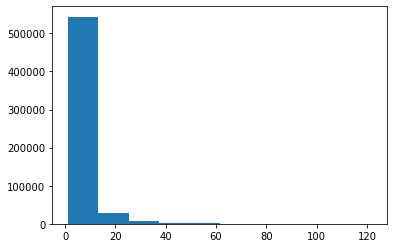

In [41]:
# 유저별 unique 방문 일자 히스토그램 확인

plt.hist(use_day.일_코드_cnt)

<BarContainer object of 122 artists>

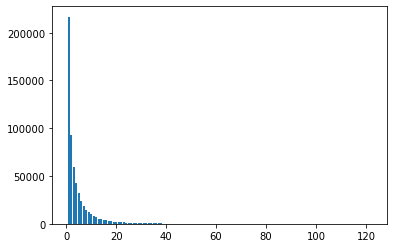

In [42]:
# 유저별 unique 방문 일자별 bar plot 확인

use_day_ratio = use_day.groupby("일_코드_cnt").nunique("유저_번호").reset_index()
plt.bar(use_day_ratio.일_코드_cnt, use_day_ratio.유저_번호)

In [43]:
# 이상치 있는지 확인 위해서 일코드_cnt 기준으로 내림차순 정렬

use_day.sort_values("일_코드_cnt", ascending = False).head(10)

,유저_번호,일_코드_cnt
301991,454280,122
525897,791240,122
250893,377301,121
154889,232737,121
72037,108171,121
135146,203116,121
474025,713089,120
159733,239964,119
37515,56460,119
505315,760191,118


In [75]:
# 일코드_cnt 가 가장 많은 유저 번호은 454280 유저가 혹시 QA 를 위한 유저가 아닌지 행동패턴 이상 여부 확인 -> 이상 없음.

pd.set_option('display.max_rows', 100)
log_data[log_data["유저_번호"]==454280].sort_values("행동일시").head(20)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
12156093,454280,GetCreditInfo,KCB 신용정보 조회,2022-03-01 05:08:02,iOS,3.6.0,2022-03-01,2022,03,01,05,08,02,1
589877,454280,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-01 05:08:07,iOS,3.6.0,2022-03-01,2022,03,01,05,08,07,1
589878,454280,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-01 05:08:08,iOS,3.6.0,2022-03-01,2022,03,01,05,08,08,1
589879,454280,CompleteIDCertification,본인인증완료,2022-03-01 05:08:29,iOS,3.6.0,2022-03-01,2022,03,01,05,08,29,1
589880,454280,EndLoanApply,한도조회_결과_확인,2022-03-01 05:09:41,iOS,3.6.0,2022-03-01,2022,03,01,05,09,41,1
12156107,454280,GetCreditInfo,KCB 신용정보 조회,2022-03-01 05:11:01,iOS,3.6.0,2022-03-01,2022,03,01,05,11,01,1
5368708,454280,OpenApp,앱_실행,2022-03-02 06:41:02,iOS,3.6.0,2022-03-02,2022,03,02,06,41,02,1
5368709,454280,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-02 06:41:13,iOS,3.6.0,2022-03-02,2022,03,02,06,41,13,1
5368710,454280,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-02 06:41:13,iOS,3.6.0,2022-03-02,2022,03,02,06,41,13,1
5368713,454280,CompleteIDCertification,본인인증완료,2022-03-02 06:41:34,iOS,3.6.0,2022-03-02,2022,03,02,06,41,34,1


#### 유저 첫_로그_일자 & 마지막_로그_일자

In [44]:
# 유저별 로그 데이터 기준 가장 처음의 로그 일자와 마지막 로그일자를 컬럼으로 생성

# 첫 로그 일자
first_log = log_data.groupby("유저_번호")["일_코드"].min().reset_index()
first_log.columns = ["유저_번호", "첫_로그_일자"]

# 마지막 로그 일자
last_log = log_data.groupby("유저_번호")["일_코드"].max().reset_index()
last_log.columns = ["유저_번호", "마지막_로그_일자"]

# use_day 기준으로 두 컬럼 모두 merge
action_cnt = pd.merge(use_day, first_log, on = "유저_번호", how = "left")
action_cnt = pd.merge(action_cnt, last_log, on = "유저_번호", how = "left")
action_cnt.head()

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자
0,1,2,2022-05-03,2022-06-16
1,7,1,2022-05-22,2022-05-22
2,9,1,2022-05-21,2022-05-21
3,11,4,2022-03-24,2022-06-13
4,12,14,2022-03-14,2022-06-30


#### 행동명별 count

In [45]:
# 각 행동명 action 수에 따른 count

action_cnt_t = action_cnt
for i in log_data["행동명_kor"].unique() :
    globals()['log_'+str(i)]  = log_data[log_data["행동명_kor"] == f"{i}"].groupby("유저_번호")["행동명_kor"].count().reset_index()
    globals()['log_'+str(i)].columns = ["유저_번호", i]
    action_cnt_t = pd.merge(action_cnt_t, globals()['log_'+str(i)], on = "유저_번호", how = 'left')

# 전체 액션 count

log_total = log_data.groupby("유저_번호")["행동명_kor"].count().reset_index()
log_total.columns = ["유저_번호","전체_이벤트"]
action_cnt_t = pd.merge(action_cnt_t, log_total, on = "유저_번호", how = "left")

print(action_cnt_t)

         유저_번호  일_코드_cnt     첫_로그_일자   마지막_로그_일자  한도조회_시작하기_버튼_클릭  \
0            1         2  2022-05-03  2022-06-16              NaN   
1            7         1  2022-05-22  2022-05-22              NaN   
2            9         1  2022-05-21  2022-05-21              NaN   
3           11         4  2022-03-24  2022-06-13              4.0   
4           12        14  2022-03-14  2022-06-30             15.0   
...        ...       ...         ...         ...              ...   
584631  879693         8  2022-05-13  2022-06-29             17.0   
584632  879694         1  2022-03-31  2022-03-31              1.0   
584633  879695         1  2022-05-27  2022-05-27              1.0   
584634  879696         1  2022-03-14  2022-03-14              NaN   
584635  879698         1  2022-05-24  2022-05-24              1.0   

        한도조회_인트로_페이지_조회  한도조회_결과_확인  앱_실행  대출관리_서비스_이용  여윳돈_계산기_서비스_이용   로그인  \
0                   NaN         NaN   NaN          1.0             NaN   1.0   
1          

In [46]:
# 879694 의 CASE 로 확인.

log_data[log_data["유저_번호"]==879694]

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
14380169,879694,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-31 20:07:23,iOS,3.6.1,2022-03-31,2022,03,31,20,07,23,1
14380170,879694,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-31 20:07:23,iOS,3.6.1,2022-03-31,2022,03,31,20,07,23,1
14380171,879694,CompleteIDCertification,본인인증완료,2022-03-31 20:07:42,iOS,3.6.1,2022-03-31,2022,03,31,20,07,42,1
14380172,879694,EndLoanApply,한도조회_결과_확인,2022-03-31 20:18:18,iOS,3.6.1,2022-03-31,2022,03,31,20,18,18,1
14380173,879694,EndLoanApply,한도조회_결과_확인,2022-03-31 20:18:18,iOS,3.6.1,2022-03-31,2022,03,31,20,18,18,1
14380174,879694,EndLoanApply,한도조회_결과_확인,2022-03-31 20:18:18,iOS,3.6.1,2022-03-31,2022,03,31,20,18,18,1


In [47]:
# 결측치 처리 -> 0

# action_cnt_t["전체_이벤트"] = action_cnt_t
action_cnt_t.fillna(0, inplace = True)

In [48]:
# 결측치 처리 확인
action_cnt_t.isnull().sum()

유저_번호              0
일_코드_cnt           0
첫_로그_일자            0
마지막_로그_일자          0
한도조회_시작하기_버튼_클릭    0
한도조회_인트로_페이지_조회    0
한도조회_결과_확인         0
앱_실행               0
대출관리_서비스_이용        0
여윳돈_계산기_서비스_이용     0
로그인                0
본인인증완료             0
DSR_계산기_서비스_이용     0
회원가입               0
KCB_신용정보_조회        0
전체_이벤트             0
dtype: int64

## 앱 실행이 아예 없는 유저 확인

In [88]:
# 앱 실행 없는 유저의 이벤트별 describe
action_cnt_t[action_cnt_t["앱_실행"] == 0].reset_index().describe()

,index,유저_번호,일_코드_cnt,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
count,166034.000000,166034.000000,166034.000000,166034.000000,166034.000000,166034.0000,166034.0,166034.000000,166034.000000,166034.000000,166034.000000,166034.000000,166034.000000,166034.000000,166034.000000
mean,292605.780671,440085.419408,1.147385,0.337057,0.367931,0.5222,0.0,0.254026,0.002945,0.312743,0.298059,0.001891,0.041088,1.592595,3.730537
std,168960.028877,254236.946417,0.433716,0.678717,0.715784,1.4052,0.0,0.764008,0.078516,0.475958,0.570230,0.046396,0.207107,1.454286,3.836001
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,146177.750000,219724.000000,1.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,292900.000000,440780.000000,1.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,439085.750000,660487.750000,1.000000,1.000000,1.000000,0.0000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,5.000000
max,584633.000000,879695.000000,18.000000,13.000000,22.000000,36.0000,0.0,53.000000,8.000000,4.000000,21.000000,3.000000,3.000000,91.000000,158.000000


In [89]:
# 전체 유저의 이벤트별 describe
action_cnt_t.describe()

,유저_번호,일_코드_cnt,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
count,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000,584636.000000
mean,439652.023676,4.666413,3.239476,3.086899,4.644348,5.919516,2.666456,0.012589,4.214169,2.117175,0.007979,0.059682,4.553255,30.521543
std,253950.752551,6.771742,7.882510,6.922166,13.125735,12.847046,7.641720,0.195624,10.835422,5.161663,0.126556,0.318121,10.651369,64.730702
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,219695.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,439943.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,10.000000
75%,659585.500000,5.000000,3.000000,3.000000,4.000000,6.000000,3.000000,0.000000,4.000000,2.000000,0.000000,0.000000,5.000000,31.000000
max,879698.000000,122.000000,789.000000,863.000000,2453.000000,1365.000000,1215.000000,25.000000,1323.000000,839.000000,23.000000,36.000000,1312.000000,6853.000000


In [81]:
# 앱 실행은 없지만, 전체 이벤는 158개인 유저 확인
action_cnt_t[(action_cnt_t["앱_실행"] == 0) & (action_cnt_t["전체_이벤트"] == 158)]

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
526177,791674,5,2022-03-25,2022-04-04,1.0,11.0,31.0,0.0,53.0,7.0,0.0,7.0,2.0,0.0,46.0,158


In [86]:
log_data[log_data["유저_번호"] == 791674].sort_values("행동일시").to_csv("791674_case_check.csv")

In [75]:
action_cnt_t["전체_이벤트"].reset_index().describe()

,index,전체_이벤트
count,584636.000000,584636.000000
mean,292317.500000,30.521543
std,168770.020326,64.730702
min,0.000000,1.000000
25%,146158.750000,3.000000
50%,292317.500000,10.000000
75%,438476.250000,31.000000
max,584635.000000,6853.000000


In [67]:
log_data[log_data["유저_번호"] == 1]

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
2451691,1,UseLoanManage,대출관리_서비스_이용,2022-06-16 23:58:41,Android,3.12.1,2022-06-16,2022,06,16,23,58,41,1
2451693,1,Login,로그인,2022-06-16 23:58:41,Android,3.12.1,2022-06-16,2022,06,16,23,58,41,1
7071607,1,GetCreditInfo,KCB_신용정보_조회,2022-06-16 23:58:42,Android,464,2022-06-16,2022,06,16,23,58,42,1
11709372,1,GetCreditInfo,KCB_신용정보_조회,2022-05-03 14:52:28,Android,464,2022-05-03,2022,05,03,14,52,28,1
11709374,1,GetCreditInfo,KCB_신용정보_조회,2022-05-03 14:52:35,Android,464,2022-05-03,2022,05,03,14,52,35,1


In [91]:
action_cnt_t

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
0,1,2,2022-05-03,2022-06-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,5
1,7,1,2022-05-22,2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,9,1,2022-05-21,2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3
3,11,4,2022-03-24,2022-06-13,4.0,5.0,7.0,5.0,9.0,1.0,0.0,4.0,0.0,0.0,8.0,43
4,12,14,2022-03-14,2022-06-30,15.0,15.0,39.0,15.0,1.0,0.0,15.0,15.0,0.0,0.0,5.0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584631,879693,8,2022-05-13,2022-06-29,17.0,10.0,12.0,9.0,5.0,0.0,0.0,6.0,0.0,0.0,2.0,61
584632,879694,1,2022-03-31,2022-03-31,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6
584633,879695,1,2022-05-27,2022-05-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
584634,879696,1,2022-03-14,2022-03-14,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,11


In [92]:
action_cnt_t["로그_diff"]= pd.to_datetime(action_cnt_t["마지막_로그_일자"]) - pd.to_datetime(action_cnt_t["첫_로그_일자"])
action_cnt_t

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,로그_diff
0,1,2,2022-05-03,2022-06-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,5,44 days
1,7,1,2022-05-22,2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days
2,9,1,2022-05-21,2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,0 days
3,11,4,2022-03-24,2022-06-13,4.0,5.0,7.0,5.0,9.0,1.0,0.0,4.0,0.0,0.0,8.0,43,81 days
4,12,14,2022-03-14,2022-06-30,15.0,15.0,39.0,15.0,1.0,0.0,15.0,15.0,0.0,0.0,5.0,120,108 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584631,879693,8,2022-05-13,2022-06-29,17.0,10.0,12.0,9.0,5.0,0.0,0.0,6.0,0.0,0.0,2.0,61,47 days
584632,879694,1,2022-03-31,2022-03-31,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0 days
584633,879695,1,2022-05-27,2022-05-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,0 days
584634,879696,1,2022-03-14,2022-03-14,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,11,0 days


In [93]:
main_event = log_data[log_data["행동명_kor"]=="한도조회_결과_확인"].groupby("유저_번호")["행동일시"].min().reset_index()
main_event["행동일시"] =  main_event.행동일시.str[0:10]
main_event.columns = ["유저_번호","첫_한도조회_결과_확인_일자"]
action_cnt_t = pd.merge(action_cnt_t, main_event, on = "유저_번호", how = "left")
action_cnt_t

# action_cnt_t.

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,로그_diff,첫_한도조회_결과_확인_일자
0,1,2,2022-05-03,2022-06-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,5,44 days,NaN
1,7,1,2022-05-22,2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0 days,NaN
2,9,1,2022-05-21,2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,0 days,NaN
3,11,4,2022-03-24,2022-06-13,4.0,5.0,7.0,5.0,9.0,1.0,0.0,4.0,0.0,0.0,8.0,43,81 days,2022-03-24
4,12,14,2022-03-14,2022-06-30,15.0,15.0,39.0,15.0,1.0,0.0,15.0,15.0,0.0,0.0,5.0,120,108 days,2022-03-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584631,879693,8,2022-05-13,2022-06-29,17.0,10.0,12.0,9.0,5.0,0.0,0.0,6.0,0.0,0.0,2.0,61,47 days,2022-05-13
584632,879694,1,2022-03-31,2022-03-31,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0 days,2022-03-31
584633,879695,1,2022-05-27,2022-05-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,0 days,2022-05-27
584634,879696,1,2022-03-14,2022-03-14,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,11,0 days,2022-03-14


In [146]:
action_cnt_t["first"]=pd.to_datetime(action_cnt_t["첫_로그_일자"]) - datetime.strptime("2022301", "%Y%m%d") 
action_cnt_t["last"]=pd.to_datetime(action_cnt_t["마지막_로그_일자"]) - datetime.strptime("2022301", "%Y%m%d") 
action_cnt_t["conversion_dt"] = pd.to_datetime(action_cnt_t["첫_한도조회_결과_확인_일자"]) -  pd.to_datetime(action_cnt_t["첫_로그_일자"])
action_cnt_t["use_dt"] = pd.to_datetime(action_cnt_t["마지막_로그_일자"]) - pd.to_datetime(action_cnt_t["첫_로그_일자"])

In [150]:
action_cnt_t[["first","last","conversion_dt","use_dt"]].isnull().sum()

first                 0
last                  0
conversion_dt    282170
use_dt                0
dtype: int64

<BarContainer object of 122 artists>

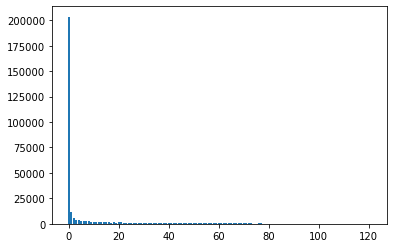

In [132]:
# a= action_cnt_t["conversion_dt"].dt.days.reset_index().groupby("conversion_dt").count().reset_index()
# a.columns= ["conversion_dt","cnt"]
plt.bar(a.conversion_dt, a.cnt)

In [154]:
action_cnt_t["로그_diff"] = action_cnt_t["로그_diff"].dt.days
action_cnt_t["first"] = action_cnt_t["first"].dt.days
action_cnt_t["last"] = action_cnt_t["last"].dt.days
action_cnt_t["conversion_dt"] = action_cnt_t["conversion_dt"].dt.days
action_cnt_t["use_dt"] = action_cnt_t["use_dt"].dt.days + 1 # 0일 사용인 경우 1일 사용으로 변경

In [155]:
action_cnt_t

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,로그_diff,첫_한도조회_결과_확인_일자,first,last,conversion_dt,use_dt
0,1,2,2022-05-03,2022-06-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,5,44,NaN,63,107,NaN,45
1,7,1,2022-05-22,2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,NaN,82,82,NaN,1
2,9,1,2022-05-21,2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,0,NaN,81,81,NaN,1
3,11,4,2022-03-24,2022-06-13,4.0,5.0,7.0,5.0,9.0,1.0,0.0,4.0,0.0,0.0,8.0,43,81,2022-03-24,23,104,0.0,82
4,12,14,2022-03-14,2022-06-30,15.0,15.0,39.0,15.0,1.0,0.0,15.0,15.0,0.0,0.0,5.0,120,108,2022-03-14,13,121,0.0,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584631,879693,8,2022-05-13,2022-06-29,17.0,10.0,12.0,9.0,5.0,0.0,0.0,6.0,0.0,0.0,2.0,61,47,2022-05-13,73,120,0.0,48
584632,879694,1,2022-03-31,2022-03-31,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0,2022-03-31,30,30,0.0,1
584633,879695,1,2022-05-27,2022-05-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,0,2022-05-27,87,87,0.0,1
584634,879696,1,2022-03-14,2022-03-14,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,11,0,2022-03-14,13,13,0.0,1


In [156]:
df_sample = action_cnt_t
df_corr = df_sample.corr()
df_corr

#ti

,유저_번호,일_코드_cnt,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,로그_diff,first,last,conversion_dt,use_dt
유저_번호,1.000000,-0.000147,0.000556,-0.000047,-0.000628,0.000185,0.000639,0.000004,0.001292,-0.000546,0.002198,-0.001785,0.000656,0.000324,-0.001000,0.000993,-0.000090,-0.002703,-0.001000
일_코드_cnt,-0.000147,1.000000,0.714120,0.778691,0.650061,0.895795,0.693136,0.085879,0.802213,0.721100,0.081573,0.097656,0.745511,0.877021,0.637401,-0.368525,0.341809,0.101858,0.637401
한도조회_시작하기_버튼_클릭,0.000556,0.714120,1.000000,0.928259,0.896771,0.755492,0.474756,0.062013,0.689956,0.907216,0.063141,0.092162,0.513012,0.881886,0.384494,-0.216581,0.212345,-0.064021,0.384494
한도조회_인트로_페이지_조회,-0.000047,0.778691,0.928259,1.000000,0.903969,0.762547,0.524197,0.076821,0.689877,0.949605,0.077209,0.105364,0.558384,0.900488,0.432174,-0.243182,0.238955,-0.038171,0.432174
한도조회_결과_확인,-0.000628,0.650061,0.896771,0.903969,1.000000,0.675137,0.445878,0.057609,0.615649,0.930871,0.053295,0.084086,0.466515,0.850017,0.340206,-0.188573,0.191182,-0.069301,0.340206
앱_실행,0.000185,0.895795,0.755492,0.762547,0.675137,1.000000,0.755224,0.085811,0.888607,0.692517,0.072167,0.106536,0.812278,0.936623,0.506677,-0.293942,0.270634,0.061401,0.506677
대출관리_서비스_이용,0.000639,0.693136,0.474756,0.524197,0.445878,0.755224,1.000000,0.172778,0.652099,0.432867,0.137240,0.071279,0.848011,0.756578,0.368234,-0.216773,0.193299,0.063538,0.368234
여윳돈_계산기_서비스_이용,0.000004,0.085879,0.062013,0.076821,0.057609,0.085811,0.172778,1.000000,-0.014137,0.062108,0.320315,0.016649,0.122849,0.091407,0.052640,-0.048449,0.008835,-0.007272,0.052640
로그인,0.001292,0.802213,0.689956,0.689877,0.615649,0.888607,0.652099,-0.014137,1.000000,0.621618,-0.017107,0.066348,0.763061,0.878746,0.422472,-0.241351,0.229684,0.053722,0.422472
본인인증완료,-0.000546,0.721100,0.907216,0.949605,0.930871,0.692517,0.432867,0.062108,0.621618,1.000000,0.059060,0.102444,0.459750,0.849578,0.403808,-0.230894,0.219315,-0.064194,0.403808


<AxesSubplot:>

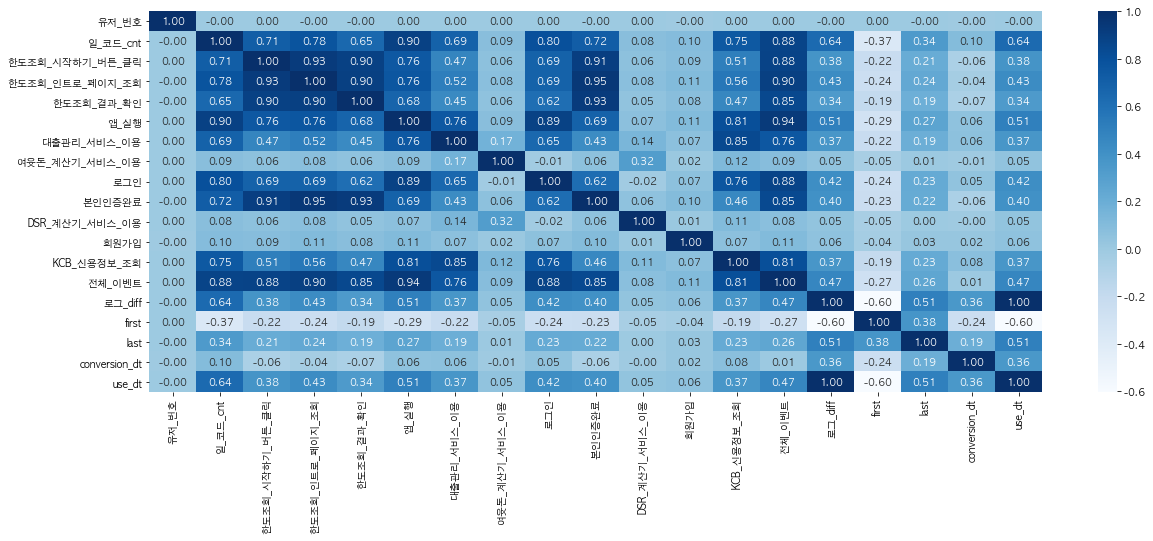

In [157]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(20,7))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="Blues")

In [ ]:
# 뻔한 행동은 나왔다고 했지만, 이런게 당연히 나오는건 가중치를 덜 줌/남들이 안하는 행동을 하는 유저에게 다른 가중치를 방법.
# 한도조회까지 몇일 까지 걸리는지.. 접ㄱ...

In [1]:
print(action_cnt_t.isnull().sum())
print(action_cnt_t[action_cnt_t["한도조회_결과_확인"] == 0].count())

NameError: name 'action_cnt_t' is not defined

In [233]:
user_spec_y = user_spec
user_spec_y["생성일시"] = user_spec_y["생성일시"].str[0:10]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,NaN,4.0,162000000.0
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,NaN,1.0,27000000.0
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,NaN,5.0,15000000.0
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,NaN,7.0,344000000.0
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0


In [245]:
loan_result.head()

,신청서_번호,한도조회_일시,금융사_번호,상품_번호,승인한도,승인금리,신청_여부(y)
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN


In [235]:
check = user_spec
check["생성일시"] = check["생성일시"].str[0:10]
check_fin = user_spec.groupby(["유저_번호","생성일시"])["한도조회_당시_유저_신용점수"].nunique()
check_fin
# check.head()

유저_번호   생성일시      
1       2022-05-03    1
7       2022-05-22    1
9       2022-05-21    1
11      2022-03-24    1
        2022-04-20    1
                     ..
879693  2022-06-27    1
879694  2022-03-31    0
879695  2022-05-27    0
879696  2022-03-14    1
879697  2022-05-10    0
Name: 한도조회_당시_유저_신용점수, Length: 1244501, dtype: int64

In [240]:
check_fin = check_fin.reset_index()
check_fin.groupby("한도조회_당시_유저_신용점수")["유저_번호"].count()

한도조회_당시_유저_신용점수
0      98816
1    1145685
Name: 유저_번호, dtype: int64

In [243]:
user_spec.isnull().sum()

신청서_번호                   0
유저_번호                    0
유저_생년월일              12961
유저_성별                12961
생성일시                     0
한도조회_당시_유저_신용점수     105115
연소득                     90
근로형태                    85
입사연월                171760
고용형태                    85
주거소유형태                  85
대출희망금액                  85
대출_목적                   85
개인회생자_여부            587461
개인회생자_납입_완료_여부     1203354
기대출수                198556
기대출금액               313774
dtype: int64

In [211]:
action_cnt_t

,유저_번호,일_코드_cnt,첫_로그_일자,마지막_로그_일자,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
0,1,2,2022-05-03,2022-06-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,5
1,7,1,2022-05-22,2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,9,1,2022-05-21,2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3
3,11,4,2022-03-24,2022-06-13,4.0,5.0,7.0,5.0,9.0,1.0,0.0,4.0,0.0,0.0,8.0,43
4,12,14,2022-03-14,2022-06-30,15.0,15.0,39.0,15.0,1.0,0.0,15.0,15.0,0.0,0.0,5.0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584631,879693,8,2022-05-13,2022-06-29,17.0,10.0,12.0,9.0,5.0,0.0,0.0,6.0,0.0,0.0,2.0,61
584632,879694,1,2022-03-31,2022-03-31,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6
584633,879695,1,2022-05-27,2022-05-27,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
584634,879696,1,2022-03-14,2022-03-14,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,11


In [161]:
log앱_실행.reset_index

AttributeError: 'function' object has no attribute 'reset_index'

In [154]:
a = log_data["행동명_kor"].unique()
for i in a : 
    log_"i}

SyntaxError: invalid syntax (<ipython-input-154-b813495baf00>, line 3)

In [145]:
log_data[log_data.유저_번호 == 11][log_data.행동명_kor == "앱_실행"]

<ipython-input-145-f679668fa700>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  log_data[log_data.유저_번호 == 11][log_data.행동명_kor == "앱_실행"]


,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
2021868,11,OpenApp,앱_실행,2022-06-09 11:23:18,iOS,NaN,2022-06-09,2022,06,09,11,23,18,1
3550216,11,OpenApp,앱_실행,2022-06-13 21:43:01,iOS,NaN,2022-06-13,2022,06,13,21,43,01,1
8380001,11,OpenApp,앱_실행,2022-04-20 10:04:10,iOS,3.7.0,2022-04-20,2022,04,20,10,04,10,1
8380067,11,OpenApp,앱_실행,2022-04-20 10:39:55,iOS,3.7.0,2022-04-20,2022,04,20,10,39,55,1
9505105,11,OpenApp,앱_실행,2022-03-24 10:53:59,iOS,3.6.1,2022-03-24,2022,03,24,10,53,59,1


In [85]:
log_data[log_data.유저_번호 == 1].head(100)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
2451691,1,UseLoanManage,대출관리_서비스_이용,2022-06-16 23:58:41,Android,3.12.1,2022-06-16,2022,06,16,23,58,41,1
2451693,1,Login,로그인,2022-06-16 23:58:41,Android,3.12.1,2022-06-16,2022,06,16,23,58,41,1
7071607,1,GetCreditInfo,KCB 신용정보 조회,2022-06-16 23:58:42,Android,464,2022-06-16,2022,06,16,23,58,42,1
11709372,1,GetCreditInfo,KCB 신용정보 조회,2022-05-03 14:52:28,Android,464,2022-05-03,2022,05,03,14,52,28,1
11709374,1,GetCreditInfo,KCB 신용정보 조회,2022-05-03 14:52:35,Android,464,2022-05-03,2022,05,03,14,52,35,1


In [84]:
log_data[log_data.유저_번호 == 1].groupby("유저_번호")["행동일시"].min()

유저_번호
1    2022-05-03 14:52:28
Name: 행동일시, dtype: object